# Урок 7. Обработка видео.

Классификация действий по видео.

## Задание.
Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH
Библиотеки: [Python, Tensorflow]

## Переключение версии TensorFlow

In [1]:
# %tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
import os
import cv2
import math
import glob
import scipy
import scipy.misc
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

2021-10-08 20:06:59.980202: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
if 1:
    !pip install scikit-video==1.1.11
    
import skvideo.io

## Загрузка и распаковка датасета KTH

In [4]:
if 1:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

if 1:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

## Подготовка датасета для классификации

In [5]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


## Разделим датасет на тренировочную и тестовую выборки.

In [30]:
random.shuffle(dataset)

test_count = math.floor(len(dataset)*0.4)

train_ds = dataset[:-test_count]
test_ds = dataset[-test_count:]

In [31]:
len(train_ds), len(test_ds)

(360, 239)

## Визуализация кадра из видео

In [32]:
dataset[0][0]

'./handclapping/person12_handclapping_d1_uncomp.avi'

videodata shape: (392, 120, 160, 3)
videodata shape: (120, 160, 3)


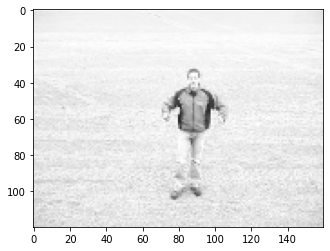

In [33]:
videodata = skvideo.io.vread(dataset[0][0]) 
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
print('videodata shape:', videodata[50, ...].shape)
plt.imshow(videodata[50, ...]) # берем 50-й кадр.

## Визуализация "движения"

motion shape: (131, 120, 160, 1)


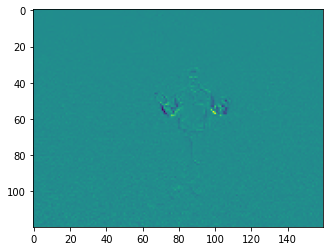

In [34]:
# Смещение изображения
motion = np.mean(videodata[0::3, ...] - videodata[1::3, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

# Подготовим pipline для загрузки видео. 

через генератор.

## Создание модели CNN

In [47]:
model = tf.keras.Sequential([                                
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [48]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 131, 120, 160, 1)
Output shape: (1, 6)


## Подготовка к обучению

In [50]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

### Данные в модель будем подавать через генератор

In [51]:
def keras_generator(dataset, batch_size=1, frames=150, image_size=(80,60)):
    c = 0
    ind = np.arange(0, len(dataset))
    random.shuffle(ind)

    while True:
        X_batch = []
        y_batch = []
        for i in range(c, c + batch_size):

            img_path, label = dataset[i]
            videodata = skvideo.io.vread(img_path)
            videodata = videodata.astype(np.float32) / 255.
            # T, M, N, C = videodata.shape
            # steps = T//step
            step = 1
            steps = frames # для того чтобы видеоролики можно было объединить в batch. к-во кадров у них должно быть одинаковым.
            motion = []
            for s in range(steps):
                # if (s+4)*step > T:
                #     break
                frame_1 = cv2.resize(videodata[s*step], image_size)
                frame_2 = cv2.resize(videodata[(s+2)*step], image_size) # s+2 - это значить картинка смещена на два кадра.
                motion.append(np.mean((frame_1 - frame_2), axis=2, keepdims=True))

            X_batch.append(motion)
            y_batch.append(label)
            
        X_batch = np.array(X_batch, dtype='float')
        y_batch = np.array(y_batch, dtype='uint8')
        
        c += batch_size
        if(c + batch_size >= len(ind)):
            c = 0
            random.shuffle(ind)

        yield X_batch, y_batch

In [52]:
# создадим массив для проверки.
batch_size = 3
frames = 150 # видео объединяемые в батч должны иметь одинаковую продолжительность по кадрам.
target_img_size = (80,60) 

train_generator = keras_generator(train_ds, batch_size=batch_size,frames=frames, image_size=target_img_size)
test_generator = keras_generator(test_ds, batch_size=batch_size,frames=frames, image_size=target_img_size)

## Цикл обучения модели

In [56]:
%%time
# global_step = 0
steps_per_epoch = len(train_ds)//batch_size
test_X, test_y = next(test_generator)
train_loss=[]
test_loss=[]

for epoch in range(NUM_EPOCHS):
    for iter in range(steps_per_epoch):

        train_X, train_y = next(train_generator)

        train_loss_value = model.train_on_batch(train_X, train_y)

        if iter % 10 == 0:
            test_loss_value = model.test_on_batch(test_X, test_y)

            test_loss.append(test_loss_value)
            train_loss.append(train_loss_value)

    print(f'[{epoch+1}/{NUM_EPOCHS}] loss: {train_loss_value}, val_loss: {test_loss_value}')

[1/10] loss: 0.7193403840065002, val_loss: 0.9513165354728699
[2/10] loss: 1.6253916025161743, val_loss: 0.3320830464363098
[3/10] loss: 2.1987462043762207, val_loss: 0.288811594247818
[4/10] loss: 0.550331711769104, val_loss: 0.21434609591960907
[5/10] loss: 0.6969903111457825, val_loss: 0.11224456876516342
[6/10] loss: 0.029065614566206932, val_loss: 0.013751504011452198
[7/10] loss: 0.9750241637229919, val_loss: 0.041540004312992096
[8/10] loss: 0.02179008163511753, val_loss: 0.011208395473659039
[9/10] loss: 0.05191255733370781, val_loss: 0.0037743477150797844
[10/10] loss: 0.04132923111319542, val_loss: 0.004058957099914551
CPU times: user 5min 43s, sys: 4min 51s, total: 10min 35s
Wall time: 24min 59s


# Посторим график обучения.

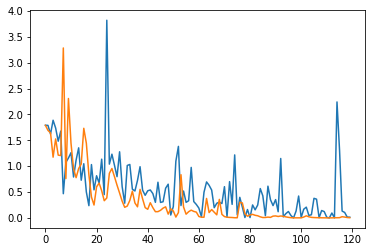

In [57]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

## Тестирование обученной модели

In [63]:
test_generator = keras_generator(test_ds, batch_size=1,frames=150, image_size=(80,60))

In [95]:
def motion_test():
    test_X, test_y = next(test_generator)

    out = model(test_X)[0]
    cls_pred = np.argmax(out.numpy())

    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(test_X[0][30, ...])
    ax[1].bar(np.arange(len(classes)), out.numpy())#, align='center')
    # ax[1].hist(out.numpy(), )

    print('True class:', classes[test_y[0]])
    print('Predicted class:', classes[cls_pred])

In [97]:
classes

['walking', 'jogging', 'running', 'boxing', 'handwaving', 'handclapping']

True class: running
Predicted class: running


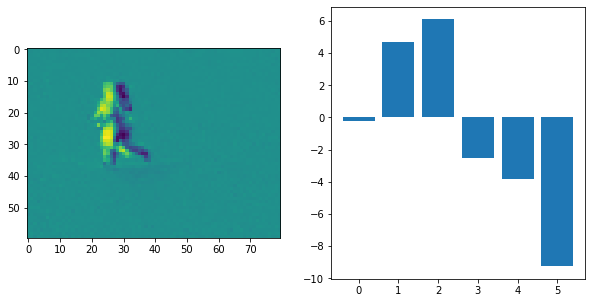

In [103]:
motion_test()

True class: handwaving
Predicted class: handclapping


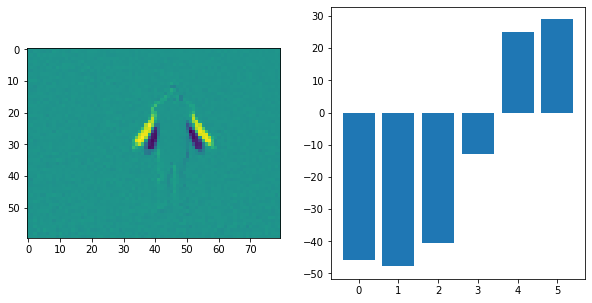

In [104]:
motion_test()

True class: boxing
Predicted class: boxing


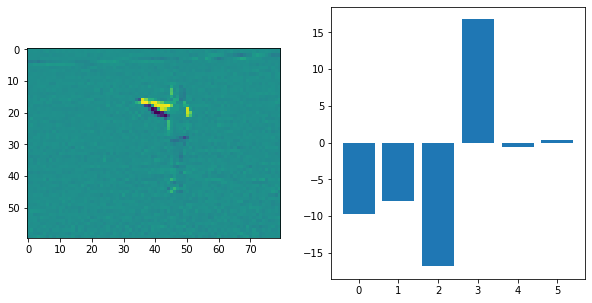

In [107]:
motion_test()

### Вывод:
 В целом, получилось неплохо. Но, некоторые типы движений модель предсказывает не так хорошо, как другие. Возможно, модель с рекуррентными слоями будет предсказывать последовательности немного лучше.